# Minimum Step Control System

Minimum step control system includes a pattern control system and no pattern control system, it belongs to one of the discrete control system, which aims to enter in the 3 typical digital controller is designed under the system and take the minimum and limited the number of end Control process, and do not in the sampling error of the moment, so take control of the minimum number of control system design in the design of this controller design is an important part of the design. In the digital control system which, in the complex plane Z domain to achieve a stable, non-error control can be achieved.(from [Minimum Step Control System Design](https://link.springer.com/chapter/10.1007/978-3-642-21697-8_21))

Consider following $G(s)$, try to design minimum step controller $D(z)$ for ramp input $r(t)=\frac{1}{2}t^2$

$$
G(s)=\frac{1}{s(s+1)}
$$

In [23]:
import control as co;
import matplotlib.pyplot as plt;
import numpy as np;

## Convert continuous time system to discrete time by sampling

从对象离散化后的传递函数可以发现，对象在z平面单位圆上（（1，0）点除外）或圆外无零点和极点，而且没有纯滞后环节。


In [24]:
Gs=co.tf(1,np.convolve([1,0],[1,1]))
Ts=0.1
Wd=co.c2d(Gs,Ts,method='zoh')
p,z=co.pzmap(Wd,plot=False)
print('G(z)=',Wd,'\nG(z) has poles',p,'and zeros',z)

G(z)= 
0.004837 z + 0.004679
----------------------
z^2 - 1.905 z + 0.9048

dt = 0.1
 
G(z) has poles [1.         0.90483742] and zeros [-0.96721849]


## Minimum Step System with Pattern

In [25]:
z=co.tf('z')
We=(1-z**(-1))**2
WB=1-We
print(WB)


2 z - 1
-------
  z^2



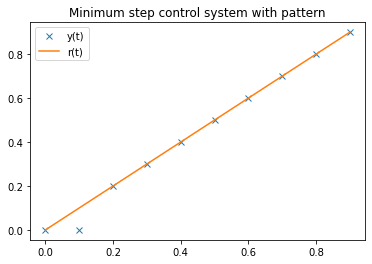

In [34]:
t=np.arange(0,1,0.1)
r=t
t,y=co.forced_response(WB,t,U=r)
plt.plot(t,y,'x',t,r,'-')
plt.title('Minimum step control system with pattern')
plt.legend(['y(t)','r(t)'])
plt.show()